# Introduction to Deep Learning: Homework 2

**Nathan Inkawhich**

**[Duke Community Standard](http://integrity.duke.edu/standard.html): By typing your name below, you are certifying that you have adhered to the Duke Community Standard in completing this assignment.**

Name: Nathan Inkawhich

**Problem 2: Practical Implementations of Optimization Functions (27 Points)**

In addition to the mathematical intuition in problem 1, it is important to see what the practical implications of such functions are. There are numerous ways to implement such functions, but there are built-in Tensorflow functions that can do this for you. Using the built in functions, i.e. (tf.train.GradientDescentOptimizer, tf.train.MomentumOptimizer, tf.train.AdamOptimizer), try out each function on your most complex MLP from HW 1. You can use any dataset you like, but MNIST is fine. Specifically, do at least the following:

- (a) Try multiple (>3) step-sizes for SGD. Determine the “optimal” constant step size.
- (b) Vary the step-size and momentum settings in SGD w/ momentum. Determine the “optimal” settings.
- (c) Use the default settings of the Adam algorithm
- (d) Vary the step-size of the Adam algorithm to see the change in how effective it works

After that, for each setting, please answer the following:

- (a) How did each algorithm qualitatively work?
- (b) How hard was it to tune your step sizes and settings?
- (c) How did each algorithm perform in validation performance estimates? 

## Imports

In [1]:
# Standard imports
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

# Import data
mnist = input_data.read_data_sets("../MNIST_data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


## 2-Hidden Layer MLP

In [2]:
# Number of hidden nodes in each hidden layer
h1_nodes = 100
h2_nodes = 100
# Number of classes in dataset
num_classes = 10

# Input placeholders: Data & GT labels
x = tf.placeholder(tf.float32, [None, 784])
y_ = tf.placeholder(tf.float32, [None, 10])

# Initialize Learnable Parameters
W_1 = tf.Variable(tf.random_normal([784, h1_nodes]))
b_1 = tf.Variable(tf.random_normal([h1_nodes]))
W_2 = tf.Variable(tf.random_normal([h1_nodes, h2_nodes]))
b_2 = tf.Variable(tf.random_normal([h2_nodes]))
W_3 = tf.Variable(tf.random_normal([h2_nodes, num_classes]))
b_3 = tf.Variable(tf.random_normal([num_classes]))

# Define Graph Structure
h_1 = tf.matmul(x, W_1) + b_1
a_1 = tf.nn.sigmoid(h_1)
h_2 = tf.matmul(a_1, W_2) + b_2
a_2 = tf.nn.sigmoid(h_2)
y_logits = tf.matmul(a_2, W_3) + b_3

# Define Cross Entropy Loss Function
xent = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_logits))

# Define accuracy operation for validation step
correct_preds = tf.equal(tf.argmax(y_logits,1),tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_preds, tf.float32))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



## Generic Training Function

Note: This function assumes the mnist dataset and the model have already been initialized in the global scope.

In [8]:
def train_step(train_optimizer, iterations, batch_size=100, val_step=250):
    with tf.Session() as sess:
        
        # Reset all variables in graph to defaults
        sess.run([tf.global_variables_initializer(), tf.local_variables_initializer()])

        # Initialize stat keepers
        val_history = []
        val_iter_history = []
        loss_history = []
        
        # Training Loop
        for i in trange(iterations):
            
            # Check if it is time to do a validation step
            #   Note: fxn is hardcoded to validate over 500 samples
            if i%val_step == 0:
                val_acc = 0
                for v in range(10):
                    batch = mnist.validation.next_batch(50)
                    val_acc += (1/10.) * accuracy.eval(feed_dict={x: batch[0], y_: batch[1]})
                val_history.append(val_acc)
                val_iter_history.append(i)
                #print("[ {} / {} ] Validation Accuracy: {}".format(i,iterations,val_acc))
            
            # Get a batch of training data and run a train step
            batch = mnist.train.next_batch(batch_size)
            loss,_ = sess.run([xent, train_optimizer], feed_dict={x: batch[0], y_: batch[1]})
            loss_history.append(loss)
            
            #if i%250 == 0:
            #    print("[ {} / {} ] Training Loss: {}".format(i,iterations,loss))
                
        # At end of training, do a test step
        print("Best Val Accuracy: {}".format(max(val_history)))
        print('Final Test Accuracy: {}'.format(accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels})))
        
        return val_history, val_iter_history, loss_history

## Vanilla SGD training with fixed step size

In [31]:
# Vanilla SGD lr sweep
train_iters = 10000
learning_rates = [1.1, 1.0, 0.9, 0.8]

val_acc = []
val_iters = []
train_loss = []

for lr in learning_rates:
    trainer = tf.train.GradientDescentOptimizer(learning_rate=lr).minimize(xent)
    print("\n*************************\nVanilla SGD; lr = {}\n*************************".format(lr))
    v_hist,v_it,t_loss = train_step(trainer, train_iters)
    val_acc.append(v_hist)
    val_iters.append(v_it)
    train_loss.append(t_loss)


*************************
Vanilla SGD; lr = 1.1
*************************


100%|██████████| 10000/10000 [00:13<00:00, 714.53it/s]


Best Val Accuracy: 0.9620000123977661
Final Test Accuracy: 0.9484000205993652

*************************
Vanilla SGD; lr = 1.0
*************************


100%|██████████| 10000/10000 [00:14<00:00, 711.84it/s]


Best Val Accuracy: 0.9639999985694885
Final Test Accuracy: 0.9496999979019165

*************************
Vanilla SGD; lr = 0.9
*************************


100%|██████████| 10000/10000 [00:13<00:00, 717.62it/s]


Best Val Accuracy: 0.9620000004768372
Final Test Accuracy: 0.9452999830245972

*************************
Vanilla SGD; lr = 0.8
*************************


100%|██████████| 10000/10000 [00:14<00:00, 712.09it/s]

Best Val Accuracy: 0.9620000004768371
Final Test Accuracy: 0.9462000131607056


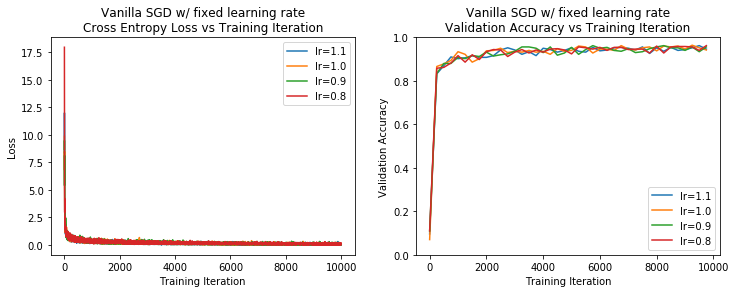

In [32]:
plt.figure(figsize=(12,4))
# Plot Training Loss Curves
plt.subplot(1,2,1)
for i in range(len(learning_rates)):
    plt.plot(train_loss[i], label="lr={}".format(learning_rates[i]))
plt.legend()
plt.title("Vanilla SGD w/ fixed learning rate\nCross Entropy Loss vs Training Iteration")
plt.xlabel("Training Iteration")
plt.ylabel("Loss")
# Validation Accuracy Curves
plt.subplot(1,2,2)
for i in range(len(learning_rates)):
    plt.plot(val_iters[i], val_acc[i], label="lr={}".format(learning_rates[i]))
plt.legend()
plt.title("Vanilla SGD w/ fixed learning rate\nValidation Accuracy vs Training Iteration")
plt.xlabel("Training Iteration")
plt.ylabel("Validation Accuracy")
plt.ylim([0.,1.])
plt.show()

## SGD with fixed-step size and momentum

In [14]:
# SGD with momentum lr sweep
train_iters = 10000
learning_rates = [0.3, 0.2, 0.1]
momentum_values = [0.9, 0.99]

val_acc = []
val_iters = []
train_loss = []

for lr in learning_rates:
    for m in momentum_values:
        trainer = tf.train.MomentumOptimizer(learning_rate=lr,momentum=m).minimize(xent)
        print("\n*************************\nSGD w/ Momentum; lr = {}; momentum = {}\n*************************".format(lr,m))
        v_hist,v_it,t_loss = train_step(trainer, train_iters)
        val_acc.append(v_hist)
        val_iters.append(v_it)
        train_loss.append(t_loss)

  0%|          | 0/10000 [00:00<?, ?it/s]


*************************
SGD w/ Momentum; lr = 0.3; momentum = 0.9
*************************


100%|██████████| 10000/10000 [00:14<00:00, 702.60it/s]


Best Val Accuracy: 0.9780000090599059
Final Test Accuracy: 0.9585000276565552

*************************
SGD w/ Momentum; lr = 0.3; momentum = 0.99
*************************


100%|██████████| 10000/10000 [00:14<00:00, 705.35it/s]


Best Val Accuracy: 0.7580000042915345
Final Test Accuracy: 0.20409999787807465

*************************
SGD w/ Momentum; lr = 0.2; momentum = 0.9
*************************


100%|██████████| 10000/10000 [00:14<00:00, 707.98it/s]


Best Val Accuracy: 0.9800000071525574
Final Test Accuracy: 0.951200008392334

*************************
SGD w/ Momentum; lr = 0.2; momentum = 0.99
*************************


100%|██████████| 10000/10000 [00:14<00:00, 707.19it/s]


Best Val Accuracy: 0.9019999980926514
Final Test Accuracy: 0.8510000109672546

*************************
SGD w/ Momentum; lr = 0.1; momentum = 0.9
*************************


100%|██████████| 10000/10000 [00:14<00:00, 681.11it/s]


Best Val Accuracy: 0.9680000007152558
Final Test Accuracy: 0.9513999819755554


  0%|          | 0/10000 [00:00<?, ?it/s]


*************************
SGD w/ Momentum; lr = 0.1; momentum = 0.99
*************************


100%|██████████| 10000/10000 [00:16<00:00, 597.52it/s]

Best Val Accuracy: 0.9719999969005584
Final Test Accuracy: 0.9584000110626221


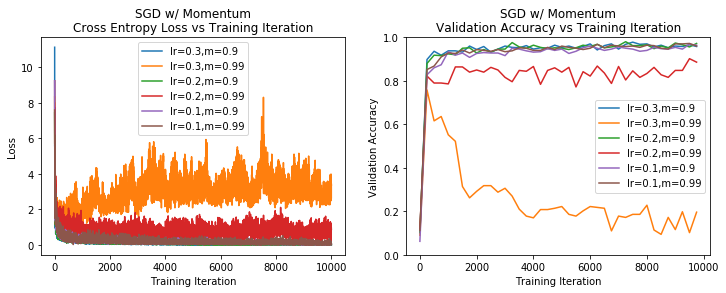

In [15]:
plt.figure(figsize=(12,4))
# Plot Training Loss Curves
plt.subplot(1,2,1)
cnt = 0
for i in range(len(learning_rates)):
    for j in range(len(momentum_values)):
        plt.plot(train_loss[cnt], label="lr={},m={}".format(learning_rates[i], momentum_values[j]))
        cnt += 1
plt.legend()
plt.title("SGD w/ Momentum\nCross Entropy Loss vs Training Iteration")
plt.xlabel("Training Iteration")
plt.ylabel("Loss")
# Validation Accuracy Curves
plt.subplot(1,2,2)
cnt = 0
for i in range(len(learning_rates)):
    for j in range(len(momentum_values)):
        plt.plot(val_iters[cnt], val_acc[cnt], label="lr={},m={}".format(learning_rates[i], momentum_values[j]))
        cnt += 1
plt.legend()
plt.title("SGD w/ Momentum\nValidation Accuracy vs Training Iteration")
plt.xlabel("Training Iteration")
plt.ylabel("Validation Accuracy")
plt.ylim([0.,1.])
plt.show()

## Adam with default settings

  0%|          | 0/10000 [00:00<?, ?it/s]


*************************
Default ADAM
*************************


100%|██████████| 10000/10000 [00:15<00:00, 644.13it/s]


Best Val Accuracy: 0.9640000045299529
Final Test Accuracy: 0.9462000131607056


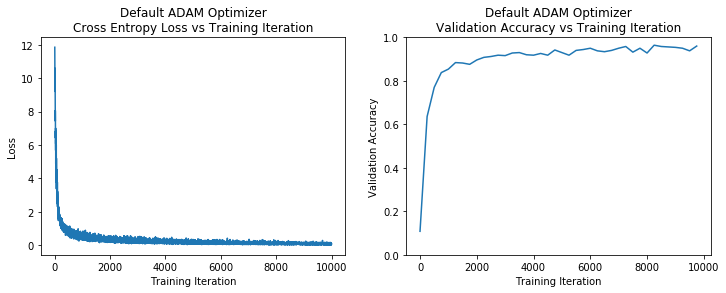

In [18]:
# Adam with default settings
train_iters = 10000

trainer = tf.train.AdamOptimizer().minimize(xent)
print("\n*************************\nDefault ADAM\n*************************")
val_acc,val_iters,train_loss = train_step(trainer, train_iters)

# Plotting
plt.figure(figsize=(12,4))
# Plot Training Loss Curves
plt.subplot(1,2,1)
plt.plot(train_loss)
plt.title("Default ADAM Optimizer\nCross Entropy Loss vs Training Iteration")
plt.xlabel("Training Iteration")
plt.ylabel("Loss")
# Validation Accuracy Curves
plt.subplot(1,2,2)
plt.plot(val_iters, val_acc)
plt.title("Default ADAM Optimizer\nValidation Accuracy vs Training Iteration")
plt.xlabel("Training Iteration")
plt.ylabel("Validation Accuracy")
plt.ylim([0.,1.])
plt.show()

## ADAM with learning rate sweep

In [29]:
train_iters = 10000
learning_rates = [0.01, 0.008, 0.005]

val_acc = []
val_iters = []
train_loss = []

for lr in learning_rates:
    trainer = tf.train.AdamOptimizer(learning_rate=lr).minimize(xent)
    print("\n*************************\nADAM; lr = {}\n*************************".format(lr))
    v_hist,v_it,t_loss = train_step(trainer, train_iters)
    val_acc.append(v_hist)
    val_iters.append(v_it)
    train_loss.append(t_loss)


*************************
ADAM; lr = 0.01
*************************


100%|██████████| 10000/10000 [00:15<00:00, 657.72it/s]


Best Val Accuracy: 0.9800000071525574
Final Test Accuracy: 0.9656999707221985

*************************
ADAM; lr = 0.008
*************************


100%|██████████| 10000/10000 [00:16<00:00, 603.65it/s]


Best Val Accuracy: 0.9760000109672546
Final Test Accuracy: 0.9664000272750854

*************************
ADAM; lr = 0.005
*************************


100%|██████████| 10000/10000 [00:15<00:00, 660.62it/s]


Best Val Accuracy: 0.9820000052452087
Final Test Accuracy: 0.9614999890327454


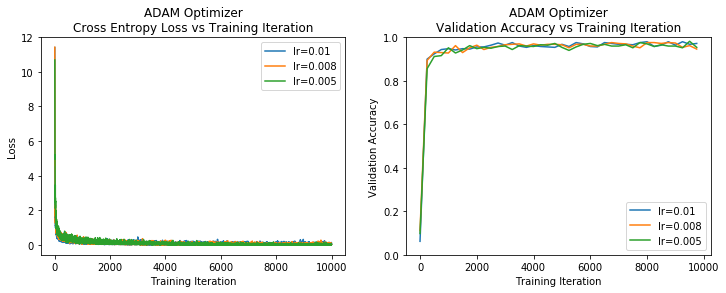

In [30]:
plt.figure(figsize=(12,4))
# Plot Training Loss Curves
plt.subplot(1,2,1)
for i in range(len(learning_rates)):
    plt.plot(train_loss[i], label="lr={}".format(learning_rates[i]))
plt.legend()
plt.title("ADAM Optimizer\nCross Entropy Loss vs Training Iteration")
plt.xlabel("Training Iteration")
plt.ylabel("Loss")
# Validation Accuracy Curves
plt.subplot(1,2,2)
for i in range(len(learning_rates)):
    plt.plot(val_iters[i], val_acc[i], label="lr={}".format(learning_rates[i]))
plt.legend()
plt.title("ADAM Optimizer\nValidation Accuracy vs Training Iteration")
plt.xlabel("Training Iteration")
plt.ylabel("Validation Accuracy")
plt.ylim([0.,1.])
plt.show()

## Questions

Note: Numerical results may vary slightly between runs due to random parameter initialization.

**(A)** How did each algorithm qualitatively work?

Overall, all algorithms performed similarly once tuned. For fair comparisons, each was trained for 10k iterations with batch size of 100. Here is a summary of the best parameters and observed validation and test accuracies from each algorithm:

    - Vanilla SGD
        - lr = 1.0
        - Val Acc: 0.9639
        - Test Acc: 0.9496

    - SGD with Momentum
        - lr = 0.3
        - momentum = 0.9
        - Val Acc: 0.9780
        - Test Acc: 0.9585

    - Default ADAM
        - lr = 0.001
        - Val Acc: 0.9640
        - Test Acc: 0.9462

    - ADAM
        - lr = 0.008
        - Val Acc: 0.9760 
        - Test Acc: 0.9664

Qualitatively, each algorithm performed "well" with the tuned ADAM performing the best.

**(B)** How hard was it to tune your step sizes and settings?

The most difficult algorithm to tune was SGD with momentum, as both learning rate and momentum value have a large impact on performance. From the validation accuracy versus iteration plot, some combinations lead to very poor performing models. Vanilla SGD was not terribly hard to tune however, I did have to do several iterations of refining the learning rate and had to guess at initial values. This algorithm also required a high learning rate as compared to the others. The default ADAM algorithm required no tuning and performed comparable to the others with no effort. When tuning ADAM, I used the default learning rate as a starting point and did not have to search hard to find the 0.008. The tuned ADAM resulted in the best performing model and was the easiest to manually tune because the default version gave a good starting point.

**(C)** How did each algorithm perform in validation performance estimates?

In these tests, the validation performance estimates were consistently higher than the final test estimates and gave a good indication of test performance. The highest achieved validation accuracy was 98.2% with the ADAM optimizer at learning rate 0.005. However, it is not fair to compare the validation accuracies across optimizers because the validation data differs between tests. Each validation estimate is computed with a random subset of 500 images from the full validation set. For a fair comparision, we would have had to do a full validation step at every point.